In [1]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from scipy.optimize import curve_fit
import matplotlib as mpl
import struct
import glob
import os 
import struct
from sklearn import linear_model
import scipy.linalg

%matplotlib inline

In [2]:
def load_obs(obs_name):
    dtype=[('name','|S20'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('delta_plus', 'f8'),
           ('delta_minus', 'f8'),
           ('vmag', 'f8'),
           ('delta_vmag', 'f8')]
    obs_data = np.loadtxt(obs_name, dtype=dtype)    
    return obs_data

In [3]:
def read_eigenvalue_binary(filename):
    f = open(filename, "rb")
    dumb = f.read(38)

    dumb = f.read(4)
    n_x = f.read(4)
    n_y = f.read(4)
    n_z = f.read(4)
    nodes = f.read(8)
    x0 = f.read(4)
    y0 = f.read(4)
    z0 = f.read(4)
    dx = f.read(4)
    dy = f.read(4)
    dz = f.read(4)
    dumb = f.read(4)

    n_x = (struct.unpack('i', n_x))[0]
    n_y = (struct.unpack('i', n_y))[0]
    n_z = (struct.unpack('i', n_z))[0]
    nodes = (struct.unpack('q', nodes))[0]
    dx = (struct.unpack('f', dx))[0]
    dy = (struct.unpack('f', dy))[0]
    dz = (struct.unpack('f', dz))[0]
    x0 = (struct.unpack('f', x0))[0]
    y0 = (struct.unpack('f', y0))[0]
    z0 = (struct.unpack('f', z0))[0]
    print(n_x, n_y, n_z, nodes, dx, dy, dz)

    total_nodes = n_x * n_y *n_z
    dumb = f.read(4)
    array_data = f.read(total_nodes*4)
    dumb = f.read(4)
    format_s = str(total_nodes)+'f'
    array_data = struct.unpack(format_s, array_data)
    f.close()
    array_data  = np.array(array_data)
    array_data.resize(n_z,n_y,n_x)
    array_data = array_data.transpose()
    return {'eigenval':array_data, 'delta_x':dx}

In [4]:
def read_eigenvector_ascii(filename, boxsize=75000.0):
    data = np.loadtxt(filename)
    ii = data[:,0]
    n_side = len(set(ii))
    print(n_side)
    delta_size = boxsize/n_side
    new_data = np.ones((3,n_side, n_side, n_side))
    n = 0 
    for i in range(n_side):
        for j in range(n_side):
            for k in range(n_side):
                new_data[:,i,j,k] = data[n,3:]
                n= n+1
    return {'eigenvec':new_data, 'delta_x':delta_size}

In [5]:
def get_environment(eigenv_1, eigenv_2, eigenv_3, eigenvec_1, eigenvec_2, eigenvec_3, pos_x=0.0, pos_y=0.0, pos_z=0.0):
    delta_x = eigenv_1['delta_x']
    i = int(pos_x//delta_x)
    j = int(pos_y//delta_x)
    k = int(pos_z//delta_x)
    norma = np.sqrt(np.sum(eigenvec_3['eigenvec'][:,i,j,k]**2))
    print('norma', i,j,k, norma)
    return {'eigen_1': eigenv_1['eigenval'][i,j,k],
                'eigen_2': eigenv_2['eigenval'][i,j,k],
                'eigen_3': eigenv_3['eigenval'][i,j,k],
                'eigenvec_3': eigenvec_3['eigenvec'][:,i,j,k]/norma, 
                'eigenvec_2': eigenvec_2['eigenvec'][:,i,j,k]/norma,
                'eigenvec_1': eigenvec_1['eigenvec'][:,i,j,k]/norma}

In [6]:
def load_snapshot(snap_name, boxsize=75000.0):
    dtype=[('subid','i8'),
           ('parentid','i8'),
           ('x', 'f8'),
           ('y', 'f8'), 
           ('z', 'f8'),
           ('vx', 'f8'),
           ('vy', 'f8'),
           ('vz', 'f8'),
           ('vmax', 'f8'),
           ('bmag', 'f8'),
           ('vmag', 'f8'),
           ('mstar', 'f8')]
    snap_data = np.loadtxt(snap_name, dtype=dtype)    
    # this takes into account periodic boudary conditions from Illustris
    for col in list(['x','y','z']):
        if((snap_data[col].max() - snap_data[col].min()) > 0.5 * boxsize):
            snap_data[col] = (snap_data[col] - 0.5 * boxsize) % boxsize
    return snap_data

In [7]:
def main_halos(snap_data):
    id_sorted = np.argsort(snap_data['mstar'])
    id_halo_A = id_sorted[-1]
    id_halo_B = id_sorted[-2]
    main_halos_data = snap_data[[id_halo_A, id_halo_B]]
    return main_halos_data

In [8]:
def satellite_halos(halo_data, halo_center):
    tmp_halo = halo_data.copy()
    radius = halo_center['vmax']/(10.0 * 100) * 1000 # in kpc/h
    for col in list(['x','y','z']):
        tmp_halo[col] = tmp_halo[col] - halo_center[col]
    r = np.sqrt(tmp_halo['x']**2 + tmp_halo['y']**2 + tmp_halo['z']**2)
    ii = (r < radius) & (r>1E-6)
    return halo_data[ii], np.min(r[ii]), np.max(r[ii])

In [9]:
def inertiaTensor(x,y,z):
    I=[]
    for index in range(9):
        I.append(0)
   
    I[0] = np.sum(y*y+z*z) 
    I[1] = np.sum(-y*x)    
    I[2] = np.sum(-x*z)    
    I[3] = np.sum(-y*x)    
    I[4] = np.sum(x*x+z*z) 
    I[5] = np.sum(-y*z)    
    I[6] = np.sum(-z*x)    
    I[7] = np.sum(-z*y)    
    I[8] = np.sum(x*x+y*y) 
    tensor = np.array([(I[0:3]), (I[3:6]), (I[6:9])])
    vals, vects = np.linalg.eig(tensor)  # they come out unsorted, so the command below is needed
    eig_ord = np.argsort(vals)  # a thing to note is that here COLUMN i corrensponds to eigenvalue i.
    ord_vals = vals[eig_ord]
    ord_vects = vects[:, eig_ord].T

    return ord_vals, ord_vects[2]

In [10]:
def get_best_plane(pos_satellites, plotting=False, unit_vector=np.array([1.0,0.0,0.0])):
    """
    Input:
    pos_satellites: Numpy structured array with the satellites positions 
                    assuming that the halo centar is at 0.0,0.0,0.0.
    """
    
    #fit the best plane with a linear regresion, this will be used for a first guess
    regr = linear_model.LinearRegression()
    X_fit = np.array([pos_satellites[0,:], pos_satellites[1,:]])
    Y_fit = np.array(pos_satellites[2,:])
    regr.fit(X_fit.T, Y_fit.T)

    #create vectors defining the planes
    #print('n satellites {}'.format(np.shape(pos_satellites)))
    n_vectors = 10000
    costheta = (np.random.random(n_vectors)-0.5)*2.0
    theta = np.cos(costheta)
    phi = np.random.random(n_vectors) * 2.0 * np.pi
    unit_vectors = np.zeros((n_vectors,3))
    unit_vectors[:,0] = np.sin(theta) * np.cos(phi)
    unit_vectors[:,1] = np.sin(theta) * np.sin(phi)
    unit_vectors[:,2] = np.cos(theta)
    
    #replace the answer from the linear fit to be the first guess. This should be the right answer for 3 points!
    # i.e. we should get a plane of zero width for three points using this vector.
    unit_vectors[0,0] = regr.coef_[0]
    unit_vectors[0,1] = regr.coef_[1]
    unit_vectors[0,2] = -1.0
    unit_vectors[0,:] = unit_vectors[0,:]/(np.sqrt(np.sum(unit_vectors[0,:]**2)))
    
    #pos_satellites = np.transpose(pos_satellites)
    
    # find distances of all points to all planes
    distances_to_planes = np.dot(unit_vectors, pos_satellites)
    percentiles = np.percentile(distances_to_planes, [16,50,84], axis=1)
    delta_plane = percentiles[2,:]-percentiles[0,:]
    
    # the best plane is the one with the minimum width
    i_min = np.argmin(delta_plane)
    
    #i_min = np.argmax(delta_plane)
    
    plane_delta = delta_plane[i_min]
    plane_center = percentiles[1,i_min]
    plane_vector = unit_vectors[i_min,:]
    
    if plotting:
        plt.scatter(delta_plane, percentiles[1,:], s = 0.1)
    #print("plane vector", plane_vector)
    return plane_delta, plane_center, plane_vector

In [19]:
def beta_velocity(pos_satellites, vel_satellites):
    """
    Compute the velocity anisotropy.
    """
    print(np.shape(pos_satellites))
    n = len(pos_satellites[0,:])
    total_v_parallel = 0.0
    total_v_perp = 0.0
    for i in range(n):
        p = pos_satellites[:,i]
        norm_p = np.sqrt(np.sum(p**2))
        v = vel_satellites[:,i]
        norm_v = np.sqrt(np.sum(v**2))
        
        v_parallel = np.sum(p*v)/norm_p
        v_perp =  np.sqrt(norm_v**2 - v_parallel**2)
        #if((v_parallel/norm_v)**2 > 0.01):
        total_v_perp += v_perp**2
        total_v_parallel += v_parallel**2
        #print(i, v_perp, v_parallel)
        #print(i, total_v_perp, total_v_parallel)
    beta = 1.0 - 0.5*total_v_perp/total_v_parallel
    return beta

In [20]:
def gen_random_sphere(n_points):
    """
    Sets of points in the 3D sphere
    """
    r = np.random.random(n_points)**(1.0/3.0)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [26]:
def spherical_randomize(x_in, y_in, z_in):
    """
    Randomizes a set of points around the coordinates origin.
    """
    n_points = len(x_in)
    r = np.sqrt(x_in**2 + y_in**2 + z_in**2)
    phi = np.random.random(n_points) * 2.0 * np.pi
    costheta = 2.0*(np.random.random(n_points) -0.5)
    theta = np.arccos(costheta)
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)
    return x, y, z

In [32]:
def sample_plane_width(x_in, y_in, z_in , n_realizations=100):
    """
    Sample the best plane width for  different n_points
    """

    p_width_all = np.zeros(n_realizations)
    p_center_all = np.zeros(n_realizations)
    for i in range(n_realizations):
        x, y, z = spherical_randomize(x_in, y_in, z_in)
        pos = np.array([x,y,z])
        p_width_all[i], p_center_all[i] , q = get_best_plane(pos)
        

    return p_width_all.mean(), p_width_all.std(), p_center_all.mean(), p_center_all.std()

In [35]:
hubble = 0.73
data_path = "../data/mstar_selected/"
output_path = "../data/mstar_selected_summary/"
data_files  = glob.glob(os.path.join(data_path, "Illustris*"))
output_A = open(os.path.join(output_path, "halo_A.dat"), "w")
output_B = open(os.path.join(output_path, "halo_B.dat"), "w")
n_pairs = len(data_files)

for i in range(n_pairs):
    # select the main halos and their satellites
    filename = os.path.join(data_path, "Illustris_group_{}.dat".format(i))
    data = load_snapshot(filename)
    main_h_data = main_halos(data)
    satellite_data_A, min_r_A, max_r_A = satellite_halos(data, main_h_data[0])
    satellite_data_B, min_r_B, max_r_B = satellite_halos(data, main_h_data[1])
    
    # select the bright satellites
    ii = satellite_data_A['vmag'] < -9.0
    satellite_data_A = satellite_data_A[ii]
    ii = satellite_data_B['vmag'] < -9.0
    satellite_data_B = satellite_data_B[ii]
    
    #number of bright satellites
    N_A = len(satellite_data_A)
    N_B = len(satellite_data_B)
    
    if((N_A>3) & (N_B>3)):
        # bright satellites
        print('pair:', i)
        print('N bright:', N_A, N_B)
        output_A.write("{}\t".format(N_A))
        output_B.write("{}\t".format(N_B))
    
        # vmax of parent DM structure
        v_max_A = main_h_data['vmax'][0]
        v_max_B = main_h_data['vmax'][1]
        output_A.write("{:.2f}\t".format(v_max_A))
        output_B.write("{:.2f}\t".format(v_max_B))
    
        #stellar mass
        m_star_A = main_h_data['mstar'][0]
        m_star_B = main_h_data['mstar'][1]
        print('mstar:', m_star_A, m_star_B)
        output_A.write("{:.2f}\t".format(m_star_A))
        output_B.write("{:.2f}\t".format(m_star_B))
         
        #distance between halos in kpc/h and vector connecting the two halos
        r_AB = np.ones(3)
        r_AB[0] = main_h_data['x'][1] - main_h_data['x'][0]
        r_AB[1] = main_h_data['y'][1] - main_h_data['y'][0]
        r_AB[2] = main_h_data['z'][1] - main_h_data['z'][0]
        d_AB =  np.sqrt(np.sum(r_AB**2))
        output_A.write("{:.2f} ".format(d_AB))
        output_A.write("{:.4f} {:.4f} {:.4f}\t".format(r_AB[0], r_AB[1], r_AB[2]))
        output_B.write("{:.2f} ".format(d_AB))
        output_B.write("{:.4f} {:.4f} {:.4f}\t".format(r_AB[0], r_AB[1], r_AB[2]))
    
        #minimum and maximum radius for the satellites
        output_A.write("{:2f} {:2f}\t".format(min_r_A, max_r_A))
        output_B.write("{:2f} {:2f}\t".format(min_r_B, max_r_B))

    
        # inertia tensor
        values, vec_a = inertiaTensor(satellite_data_A['x']-main_h_data['x'][0], 
                                satellite_data_A['y']-main_h_data['y'][0], 
                                satellite_data_A['z']-main_h_data['z'][0])
        output_A.write("{:.2e}  {:.2e}  {:.2e} ".format(values[0], values[1], values[2]))
        output_A.write("{:.4f}  {:.4f}  {:.4f}\t ".format(vec_a[0], vec_a[1], vec_a[2]))
        values, vec_a = inertiaTensor(satellite_data_B['x']-main_h_data['x'][1], 
                                satellite_data_B['y']-main_h_data['y'][1], 
                                satellite_data_B['z']-main_h_data['z'][1])
        output_B.write("{:.2e}  {:.2e}  {:.2e} ".format(values[0], values[1], values[2]))
        output_B.write("{:.4f}  {:.4f}  {:.4f}\t".format(vec_a[0], vec_a[1], vec_a[2]))
        
        # finding the best planes 
        plane_w, plane_c, plane_v = get_best_plane(np.array([satellite_data_A['x']-main_h_data['x'][0],
                                                            satellite_data_A['y']-main_h_data['y'][0],
                                                            satellite_data_A['z']-main_h_data['z'][0]]))
        output_A.write("{:.2f} {:.2f} ".format(plane_w, plane_c))
        output_A.write("{:.4f} {:.4f} {:.4f}\t".format(plane_v[0], plane_v[1], plane_v[2]))
        
        plane_w, plane_c, plane_v = get_best_plane(np.array([satellite_data_B['x']-main_h_data['x'][1],
                                                            satellite_data_B['y']-main_h_data['y'][1],
                                                            satellite_data_B['z']-main_h_data['z'][1]]))
        output_B.write("{:.2f} {:.2f} ".format(plane_w, plane_c))
        output_B.write("{:.4f} {:.4f} {:.4f}\t".format(plane_v[0], plane_v[1], plane_v[2]))

        #planes from randomized data
        p_width_mean, p_width_std, p_center_mean, p_center_std = sample_plane_width(
                            satellite_data_A['x']-main_h_data['x'][0], 
                            satellite_data_A['y']-main_h_data['y'][0], 
                            satellite_data_A['z']-main_h_data['z'][0], n_realizations=200)
        output_A.write("{:.4f} {:.4f} {:.4f} {:.4f}\t".format(p_width_mean, p_width_std, p_center_mean, p_center_std))
        
        p_width_mean, p_width_std, p_center_mean, p_center_std = sample_plane_width(
                            satellite_data_B['x']-main_h_data['x'][1], 
                            satellite_data_B['y']-main_h_data['y'][1], 
                            satellite_data_B['z']-main_h_data['z'][1], n_realizations=200)
        output_B.write("{:.4f} {:.4f} {:.4f} {:.4f}\t".format(p_width_mean, p_width_std, p_center_mean, p_center_std))
        
        # velocity anisotrpy
        beta_A = beta_velocity(np.array([satellite_data_A['x']-main_h_data['x'][0],
                               satellite_data_A['y']-main_h_data['y'][0],
                                satellite_data_A['z']-main_h_data['z'][0]]), 
                      np.array([satellite_data_A['vx']-main_h_data['vx'][0],
                               satellite_data_A['vy']-main_h_data['vy'][0],
                                satellite_data_A['vz']-main_h_data['vz'][0]]))
        output_A.write("{:.2f}\t".format(beta_A))
        
        beta_B = beta_velocity(np.array([satellite_data_B['x']-main_h_data['x'][1],
                               satellite_data_B['y']-main_h_data['y'][1],
                                satellite_data_B['z']-main_h_data['z'][1]]), 
                      np.array([satellite_data_B['vx']-main_h_data['vx'][1],
                               satellite_data_B['vy']-main_h_data['vy'][1],
                                satellite_data_B['vz']-main_h_data['vz'][1]]))
        output_B.write("{:.2f}\t".format(beta_B))
    
 
        output_A.write("\n")
        output_B.write("\n")
        print()
output_A.close()
output_B.close()
    

pair: 0
N bright: 23 13
mstar: 7.627908 2.500447
(3, 23)
(3, 13)

pair: 1
N bright: 15 9
mstar: 5.431979 3.656405
(3, 15)
(3, 9)

pair: 2
N bright: 20 4
mstar: 5.455789 1.472944
(3, 20)
(3, 4)

pair: 4
N bright: 4 12
mstar: 4.589331 4.278156
(3, 4)
(3, 12)

pair: 5
N bright: 12 9
mstar: 6.440929 5.226757
(3, 12)
(3, 9)

pair: 6
N bright: 23 6
mstar: 3.395247 3.225855
(3, 23)
(3, 6)

pair: 7
N bright: 10 5
mstar: 5.786866 4.090054
(3, 10)
(3, 5)

pair: 8
N bright: 9 4
mstar: 6.544223 4.266023
(3, 9)
(3, 4)

pair: 9
N bright: 20 6
mstar: 3.666521 3.294355
(3, 20)
(3, 6)

pair: 12
N bright: 5 6
mstar: 1.494109 0.853785
(3, 5)
(3, 6)

pair: 15
N bright: 5 5
mstar: 1.164485 0.791704
(3, 5)
(3, 5)



n satellites (3, 13)


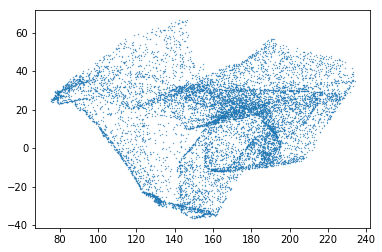

In [15]:
    # select the main halos and their satellites
i=0
filename = os.path.join(data_path, "Illustris_group_{}.dat".format(i))
data = load_snapshot(filename)
main_h_data = main_halos(data)
satellite_data_A = satellite_halos(data, main_h_data[0])
satellite_data_B = satellite_halos(data, main_h_data[1])
  # select the bright satellites
ii = satellite_data_A['vmag'] < -9.0
satellite_data_A = satellite_data_A[ii]
ii = satellite_data_B['vmag'] < -9.0
satellite_data_B = satellite_data_B[ii]
plane_w, plane_c, plane_v = get_best_plane(np.array([satellite_data_B['x']-main_h_data['x'][1],
                                                            satellite_data_B['y']-main_h_data['y'][1],
                                                            satellite_data_B['z']-main_h_data['z'][1]]), plotting=True)